# 依赖

In [1]:
import matplotlib.pyplot as plt
from skimage import io,data,draw,color,transform,feature
import cv2
import numpy as np
import math
from math import cos, sin, pi, tan
from mpl_toolkits.mplot3d import Axes3D
# 求解方程组
import sympy
# %matplotlib inline 

# 函数

## 功能函数

In [230]:
#对所有的空间中坐标点进行投影
#x = xc*f/zc
#y = yc*f/zc
def xyz_draw(points, name='1'):
    '''
    # 画三维点
    # points:三维点 np.array:3×m
    # name:画板名称 str
    '''
    fig = plt.figure(name)
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])

def xyz_projection(points, name='1', draw_flag=False, f=0.03):
    '''
    # 射影变换x,y = xyz_projection()
    # points:三维点 np.array:m*3
    # name:画板名称 str
    # draw_flag:是否画图 bool
    # output：返回射影变化后的x,y
    '''
    K = np.array([[f, 0, 0],
            [0, f, 0],
            [0, 0, 1]])
    points_projection = np.dot(K, points.T)/points[:, 2].T
    x = points_projection[0,:]
    y = points_projection[1,:]
    z = np.zeros((len(x), 1)) + f
    
    if draw_flag:
        fig = plt.figure('projection')
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.scatter(points[:,0], points[:,1], points[:,2])
        ax.scatter(x, y, z)
        for ii in range(0,len(x), 5):#画投影线
            ax.plot3D([points[ii, 0], x[ii]], [points[ii, 1], y[ii]], [points[ii, 2], z[ii]])
        #画焦平面
        plt.figure('jiao flat')
        plt.plot(x, y, '.r')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axis('equal')
        
    return x, y

# 旋转轴v1v2：v1(a1, b1, c1), v2(a2, b2, c2)
# 旋转角度theta
# 位移矩阵
def xyz_rotation(points, r_theta = 0, r_axis=[1, 0, 0], p1 = [0, 0, 0], name='rotation', draw_flag=False):
    '''
    获得旋转矩阵，并变化 r_theta, r_axis, points_extent_draw, RR = xyz_rotation()
    ---------------
    points:三维点 np.array:m*3
    p1:[a, b, c]起点（这里设置为[0,0,0]）
    r_theta:旋转角度 弧度 逆时针
    name:画板名称 str
    r_axis:旋转轴 [u,v,w]
    draw_flag:是否画图 bool
    ---------------
    output：返回旋转角（弧度）theta，旋转轴归一化r_axis，变化后的点points_extent_draw:m*4
    RR:np.array 4*4
    ---------------
    '''
    theta = r_theta
    points_extent = np.hstack((points, np.ones((points.shape[0],1))))
    #theta = -i/20*pi
    #[a1, b1, c1] = [125, 125, 10]
    #[a, b, c] = [1, 0, 0]
    #T1 = np.array([[1,0,0,-a1],
                  #[0,1,0,-b1],
                  #[0,0,1,-c1],
                  #[0,0,0,1]])
    #T2 = np.array([[1,0,0,a1],
                  #[0,1,0,b1],
                  #[0,0,1,c1],
                  #[0,0,0,1]])
    #R = np.array([[a**2+(1-a**2)*cos(theta), a*b*(1-cos(theta))+c*cos(theta), a*c*(1-cos(theta))-b*sin(theta), 0],
                 #[a*b*(1-cos(theta))-c*sin(theta), b**2+(1-b**2)*cos(theta), b*c*(1-cos(theta))+a*sin(theta), 0],
                 #[a*c*(1-cos(theta)+b*sin(theta)), b*c*(1-cos(theta))-a*sin(theta), c**2+(1-c**2)*cos(theta), 0],
                 #[0, 0, 0, 1]])
    if np.linalg.norm(np.array(r_axis), 2)==0:
        return -1
    else:
        #[u, v, w] = [1, 0, 0]#旋转轴，需要是单位向量
        r_axis = np.array(r_axis)/np.linalg.norm(np.array(r_axis), 2)
        [u, v, w] = r_axis
    [a, b, c] = p1[:]
    #[a, b, c] = [125, 125, 10]#第一个点，位移向量
    #[a, b, c] = [0, 0, 0]
    #theta = pi/4
    RR = np.array([[u**2+(v**2+w**2)*cos(theta), u*v*(1-cos(theta))-w*sin(theta), u*w*(1-cos(theta))+v*sin(theta), (a*(v**2+w**2)-u*(b*v+c*w))*(1-cos(theta))+(b*w-c*v)*sin(theta)],
                   [u*v*(1-cos(theta))+w*sin(theta), v**2+(u**2+w**2)*cos(theta), v*w*(1-cos(theta))-u*sin(theta), (b*(u**2+w**2)-v*(a*u+c*w))*(1-cos(theta))+(c*u-a*w)*sin(theta)],
                   [u*w*(1-cos(theta))-v*sin(theta), u*w*(1-cos(theta))+u*sin(theta), w**2+(u**2+v**2)*cos(theta), (c*(w**2+v**2)-w*(a*u+b*v))*(1-cos(theta))+(a*v-b*u)*sin(theta)],
                   [0, 0, 0, 1]])

    
    #print(RR)
    points_extent_draw = points_extent.dot(RR.T)
    #points_extent_draw1 = points_extent.dot(T1.dot(R).dot(T2))
    if draw_flag:
        fig = plt.figure(name)
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.scatter(points[:,0], points[:,1], points[:,2])
        ax.scatter(points_extent_draw[:,0], points_extent_draw[:,1], points_extent_draw[:,2])
        #ax.scatter(points_extent_draw1[:,0], points_extent_draw1[:,1], points_extent_draw1[:,2], 'b')
        ax.plot3D([a, a+u*100], [b, b+v*100], [c, c+w*100], 'r')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    return r_theta, r_axis, points_extent_draw, RR

def xyz_getCircle(xc, yc, r, num=1000):
    '''
    # 画圆 x,y = xyz_getCircle(xc, yc, r)
    # xc:float
    # yc:float
    # r:float
    # num:点的数目
    # output:
    # x:np.array:1*m
    # y:np.array:1*m
    '''
    theta = np.linspace(0, 2*pi, num)
    x = r*np.cos(theta) + xc
    y = r*np.sin(theta) + yc
    return x, y

def xyz_ellipse_fx(theta, xe, ye, a, b, phi):
    '''
    椭圆参数方程：x = xyz_ellipse_fx()
    theta:np.array弧度集合
    xe:float
    ye:float
    a:float
    b:float
    phi:float弧度
    output:
    x:np.array
    '''
    return a*cos(phi)*np.cos(theta) - b*sin(phi)*np.sin(theta) + xe
def xyz_ellipse_fy(theta, xe, ye, a, b, phi):
    '''
    椭圆参数方程：y = xyz_ellipse_fy()
    theta:np.array弧度集合
    xe:float
    ye:float
    a:float
    b:float
    phi:float弧度
    output:
    y:np.array
    '''
    return a*sin(phi)*np.cos(theta) + b*cos(phi)*np.sin(theta) + ye
def xyz_getEllipse(xe, ye, a, b, phi, num=1000):
    '''
    x,y=xyz_getEllipse()
    xe:float
    ye:float
    a:float
    b:float
    phi:float弧度，a轴和x轴方向的倾斜角
    num:正整数 点的数目 
    output:
    x:np.array
    y:np.array
    '''
    theta = np.linspace(0, 2*pi, num)
    x = xyz_ellipse_fx(theta, xe, ye, a, b, phi)
    y = xyz_ellipse_fy(theta, xe, ye, a, b, phi)
    return x, y

def xyz_getExtremumFromEllipse(xe, ye, a, b, phi):
    '''
    获得椭圆的四个极值点 Ay, By, Ax, Bx = xyz_getExtremumFromEllipse()
    xe:float
    ye:float
    a:float
    b:float
    phi:float弧度
    output:
    四个点都是长度为2的list
    Ay, By:代表在y轴上的两个极值点,Ay.y<By.y，By点在最上方点，Ay最下方点
    Ax, Bx:代表在x轴上的两个极值点,Ax.x<Bx.x，Bx点在最右方点，Ax最左方点
    '''
    if phi==0:
        theta_x = 0
        theta_y = pi/2
    else:
        #x的极值
        theta_x = math.atan(-b*sin(phi)/(a*cos(phi)))
        #y的极值
        theta_y = math.atan( b*cos(phi)/(a*sin(phi)))
    if xyz_ellipse_fx(theta_x, xe, ye, a, b, phi)<xyz_ellipse_fx(theta_x+pi, xe, ye, a, b, phi):
        Ax_x = xyz_ellipse_fx(theta_x, xe, ye, a, b, phi)
        Ax_y = xyz_ellipse_fy(theta_x, xe, ye, a, b, phi)
        Bx_x = xyz_ellipse_fx(theta_x+pi, xe, ye, a, b, phi)
        Bx_y = xyz_ellipse_fy(theta_x+pi, xe, ye, a, b, phi)
    else:
        Ax_x = xyz_ellipse_fx(theta_x+pi, xe, ye, a, b, phi)
        Ax_y = xyz_ellipse_fy(theta_x+pi, xe, ye, a, b, phi)
        Bx_x = xyz_ellipse_fx(theta_x, xe, ye, a, b, phi)
        Bx_y = xyz_ellipse_fy(theta_x, xe, ye, a, b, phi)

    if xyz_ellipse_fy(theta_y, xe, ye, a, b, phi)<xyz_ellipse_fy(theta_y+pi, xe, ye, a, b, phi):
        Ay_x = xyz_ellipse_fx(theta_y, xe, ye, a, b, phi)
        Ay_y = xyz_ellipse_fy(theta_y, xe, ye, a, b, phi)
        By_x = xyz_ellipse_fx(theta_y+pi, xe, ye, a, b, phi)
        By_y = xyz_ellipse_fy(theta_y+pi, xe, ye, a, b, phi)
    else:
        Ay_x = xyz_ellipse_fx(theta_y+pi, xe, ye, a, b, phi)
        Ay_y = xyz_ellipse_fy(theta_y+pi, xe, ye, a, b, phi)
        By_x = xyz_ellipse_fx(theta_y, xe, ye, a, b, phi)
        By_y = xyz_ellipse_fy(theta_y, xe, ye, a, b, phi)
    Ax = [Ax_x, Ax_y]
    Bx = [Bx_x, Bx_y]
    Ay = [Ay_x, Ay_y]
    By = [By_x, By_y]
    return Ay, By, Ax, Bx

## 计算函数

In [19]:
def xyz_getRelationData(f = 30*1e-3, Pc=[100, 100, 100], radius=60, r_axis=[1, 1, 0], r_theta=0*pi/180, draw_flag=False, draw_result=False, scal=10000):
    '''
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle
    = xyz_getRelationData()
    -已知f, radius, Pc, r_axis, r_theta, 生成空间中的圆，并进行成像
    -拟合椭圆时需要注意，使用的是cv.fitellipse()，需要拟合点是整数，为了保证精度问题，xyz_fitEllipse(ff_x, ff_y, scal=10000)
    -可以更改scal, 值越大精度越大
    #input
    #相机焦距f:float
    #圆中心坐标Pc:list:[xc, yc, zc]
    #圆半径radius:float
    #旋转轴r_axis:list:[u, v, w]
    #旋转角度r_theta:float:弧度（逆时针旋转）
    #draw_flag:plot圆成像过程
    #draw_result:plot拟合椭圆结果
    #scal:拟合椭圆参数
    #output
    #相机焦距f:float
    #圆中心坐标Pc:list:[xc, yc, zc]
    #圆半径radius:float
    #旋转轴r_axis:list:[u, v, w]
    #旋转角度r_theta:float:弧度（逆时针旋转）
    #旋转矩阵：RR:np.array:3*3 (RR=f(r_axis, r_theta))
    #圆中心在焦平面射影：[ff_xc, ff_yc]:list
    #四个极值点：Ay, By, Ax, Bx
            Ay, By:代表在y轴上的两个极值点,Ay.y<By.y，By点在最上方点，Ay最下方点
            Ax, Bx:代表在x轴上的两个极值点,Ax.x<Bx.x，Bx点在最右方点，Ax最左方点
    #焦平面椭圆圆心：e_center:list:[xe, ye]
    #焦平面椭圆长短轴：e_axes:list:[a, b]
    #焦平面椭圆倾斜角：e_angle:float:弧度（逆时针旋转）
    '''
    #空间中的圆
    #f = 30*1e-3
    #du = 12e-4#像元尺寸
    #在z=0的空间平面上画圆，获得以(0, 0)为圆心坐标，60为半径的圆
    r = radius
    #初始圆心在原点处
    xc, yc, zc = 0, 0, 0
    x, y = xyz_getCircle(xc, yc, r, num=500)
    #获得物方点points
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    points[:, 2] = zc
    #将空间的点绕轴旋转
    r_theta, r_axis, r_points, RR = xyz_rotation(points, r_theta=r_theta, r_axis=r_axis, draw_flag=draw_flag)
    #平移到圆心处
    xc, yc, zc = Pc[:]
    r_points[:, 0] += xc
    r_points[:, 1] += yc
    r_points[:, 2] += zc
    #焦平面成像
    ff_x, ff_y = xyz_projection(r_points[:, 0:3], 'focal falt', draw_flag=draw_flag, f=f)
    #圆中心投影
    ff_xc, ff_yc = xyz_projection(np.array(Pc).reshape((1,3)), f=f)
    #找到焦平面上的椭圆
    e_center, e_axes, e_angle = xyz_fitEllipse(ff_x, ff_y, scal=scal)
    #e_angle = e_angle*pi/180
    #找到拟合椭圆的极值
    Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    if draw_result:
        xyz_showResult(e_center, e_axes, e_angle, ff_x, ff_y, ff_xc, ff_yc, Ay, By, Ax, Bx, name='r_theta is ' + str(r_theta*180/pi) + '°')
    return f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle

def xyz_showResult(e_center, e_axes, e_angle, ff_x, ff_y, ff_xc, ff_yc, Ay, By, Ax, Bx, name='ellipse'):
    '''
    xyz_showResult(e_center, e_axes, e_angle, ff_x, ff_y, ff_xc, ff_yc, Ay, By, Ax, Bx)
    -显示生成空间圆数据，旋转后，到焦平面投影，焦平面成像拟合椭圆，这一系过程结果
    -如果只生成两个椭圆重叠，说明拟合成功，如果不成功，说明拟合欠佳
    #焦平面椭圆圆心：黑色点：e_center:list:[xe, ye]
    #焦平面椭圆长短轴：e_axes:list:[a, b]
    #焦平面椭圆倾斜角：e_angle:float:弧度（逆时针旋转）
    #焦平面上的点：ff_x, ff_y:np.array:1*m
    #圆中心在焦平面射影：ff_xc, ff_yc:float
    #四个极值点：Ay, By, Ax, Bx（y轴极值点连线，红线，x轴极值点连线，蓝线）
    #空间圆绕着某轴的旋转角度：name:str(角度)
    '''
    xx, yy = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle, num=1000)
    plt.figure(name)
    plt.plot(ff_x, ff_y, label='circle projection')
    plt.plot(Ay[0], Ay[1], 'ro', label='Ay')
    plt.plot(Ax[0], Ax[1], 'bo', label='Ax')
    plt.plot(By[0], By[1], 'r*', label='By')
    plt.plot(Bx[0], Bx[1], 'b*', label='Bx')
    plt.plot(e_center[0], e_center[1], 'yo', label='ellipse center')
    plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
    plt.plot([Ay[0], By[0]], [Ay[1], By[1]], 'r', label='line AyBy')
    plt.plot([Ax[0], Bx[0]], [Ax[1], Bx[1]], 'b', label='line AxBx')
    plt.plot(xx, yy, label='fitEllipse result')
    plt.legend(loc=1)
    ##plt.axis([-0.01, 0.08, -0.01, 0.08], 'equal')
    #my_x_ticks = np.arange(-0.01, 0.09, 0.01)
    #my_y_ticks = np.arange(-0.01, 0.09, 0.01)
    #plt.xticks(my_x_ticks)
    #plt.yticks(my_y_ticks)
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')

### 获得直线

In [4]:
def xyz_getLine(xo, yo, gamma, num=10, length=1):
    '''
    x,y = xyz_getLine()
    ---------------
    点斜式画线，num点数，length,x线长度的2倍
    需要使用到numpy, math
    import numpy as np
    from math import pi
    ---------------
    input:
    xo,yo:线上一点:float
    gamma:倾斜角:float[0-pi]:弧度
    ---------------
    output:
    x:np.array:10*1:x = np.arange(xo-length, xo+length, length/num)
    y:np.array:10*1
    ---------------
    '''
    if gamma>=0 and gamma<=pi:
        # 点斜式方程
        x = np.arange(xo-length, xo+length, length/num)
        # 点斜式，当gamma=pi/2时，y值需要特殊考虑
        if gamma==pi/2:
            y = np.arange(yo-length, yo+length, length/num)
            x = np.zeros(y.shape) + xo
        else:
            y = (x-xo)*np.tan(gamma) + yo
        return x, y
    else:
        print('error:gamma 范围必须要在[0, pi]内！')
        return None, None

### 求解直线和椭圆交点

${\frac{(x-xe)^{2}}{a^{2}} + \frac{(y-ye)^{2}}{b^{2}} = 1}$  
${\frac{(cos(\phi)*(x^{'}-xe) + sin(\phi)*(y^{'}-ye))^{2}}{a^{2}} + \frac{(- sin(\phi)*(x^{'}-xe) + cos(\phi)*(y^{'}-ye))^{2}}{b^{2}} = 1}$  

In [5]:
def xyz_calcIntersectionOfLineAndEllipse(xo, yo, gamma, xe, ye, a, b, phi):
    '''
    [ax, ay], [bx, by] = xyz_calcIntersectionOfLineAndEllipse()
    ------------------
    计算线和椭圆的两个交点
    需要使用sympy库进行计算
    ------------------
    input:
    line:点斜式：xo,yo,gamma:float
    ellipse:标准方程：xe,ye,a,b,phi:float
    ------------------
    output:
    ax,ay:float
    bx,by:float
    (ay>by)，如果ay=by，则ax>bx
    ------------------
    '''
    x, y = sympy.symbols('x, y')
    if gamma==pi/2:
        # 平行于y轴的直线,直接将x=xo作为约束即可
        result = sympy.solve([x-xo, (cos(phi)*(x-xe)+sin(phi)*(y-ye))**2/(a**2) + \
                             (-sin(phi)*(x-xe)+cos(phi)*(y-ye))**2/(b**2)-1], [x, y])
    else:
        result = sympy.solve([(x-xo)*tan(gamma)+yo-y, (cos(phi)*(x-xe)+sin(phi)*(y-ye))**2/(a**2) + \
                             (-sin(phi)*(x-xe)+cos(phi)*(y-ye))**2/(b**2)-1], [x, y])
    if len(result)!=2:
        print('error：解的个数少于两个！')
        return result
    else:
        [(ax, ay), (bx, by)] = result
        if ay<by:
            ax, bx = bx, ax
            ay, by = by, ay
        if ay==by and ax<bx:
            ax, bx = bx, ax
            ay, by = by, ay
    # 这里由于返回的值是tuple，转为float
    return [float(ax), float(ay)], [float(bx), float(by)]

### 求解过圆心投影线对应空间中的一点

In [6]:
def xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=0, f=0.03, radius=60, show_message=False):
    '''
    [xc, yc, zc], [xa, ya, za], voa, vob, voc, phi = xyz_calcCircleCenterAndAPoint()
    -----------------
    已知圆半径radius，相机焦距f，圆中心投影C'(ff_xc, ff_yc)，
    圆射影椭圆5个参数(xe, ye, a, b, phi)，
    过C'中心的直线倾斜角gamma(和x轴正方向的夹角0-pi)，逆时针，弧度;
    求AC = line(C', gamma)对应的圆中心，和圆上一点A
    ----------------
    input:
    ff_xc, ff_yc:圆中心射影坐标：float
    xe,ye,a,b,phi：椭圆五个参数(a,b是长短轴的一半，phi是倾斜角，逆时针，弧度):float
    gamma：过C’中心的直线倾斜角，逆时针，弧度:float
    ----------------
    output:
    [xc, yc, zc]:圆中心坐标:float
    [xa, ya, za]:AC = line(C', gamma),A的坐标:float
    phi:CB和Z轴的夹角：弧度：float：取值范围[0, pi/2]
    -old:phi:CB和xoy平面的夹角：弧度：float
    ----------------
    '''
    # 获得过C‘，倾斜角为gamma的直线和椭圆的交点
    # Ay>By; Ay==By,Ax>Bx
    [Ax, Ay], [Bx, By] = xyz_calcIntersectionOfLineAndEllipse(ff_xc, ff_yc, gamma, xe, ye, a, b, phi)
    # 论文中的A，B点在光心C的左像平面上，模拟成像在右像平面上，A，B两点正好关于关心C对称
    Ax, Ay, Bx, By = Bx, By, Ax, Ay
    
    # 获得Intrinsic matrix（内参矩阵）
    K = np.array([[f, 0, 0],
                 [0, f, 0],
                 [0, 0, 1]])

    # 式(1)，求三个向量在空间中的直线方向向量
    voa = np.dot(np.linalg.inv(K), np.array([Ax, Ay, 1]))
    voa = voa/np.linalg.norm(voa, 2)
    vob = np.dot(np.linalg.inv(K), np.array([Bx, By, 1]))
    vob = vob/np.linalg.norm(vob, 2)
    voc = np.dot(np.linalg.inv(K), np.array([float(ff_xc), float(ff_yc), 1]))
    voc = voc/np.linalg.norm(voc, 2)
    if show_message:
        print('- 三个向量：')
        print(voa)
        print(vob)
        print(voc)

    # 式(2,3)，求解两个theta角
    theta1 = math.acos(np.dot(voa, voc))
    theta2 = math.acos(np.dot(vob, voc))
    if show_message:
        print('- 两个theta角度：')
        print(theta1/pi*180, theta2/pi*180)

    # 式(4,5)，求解圆心到原点的距离OC
    oc_length = math.sqrt(2)*radius*sin(theta1+theta2)/math.sqrt(3-2*cos(2*theta1)-2*cos(2*theta2)+cos(2*(theta1+theta2)))
    if show_message:
        print('- 圆半径，oc投影长度')
        print(radius, oc_length)
    
    # 式(6,7,8)，按照(6,7)求得可行的四组解，然后找到一组满足(8)式的正确解
    gama1_1 = math.asin(oc_length/radius*sin(theta1))
    gama1_2 = pi - gama1_1
    beta2_1 = math.asin(oc_length/radius*sin(theta2))
    beta2_2 = pi - beta2_1
    if show_message:
        print('- gama1, beta2分别可能的2个解：')
        print(gama1_1*180/pi, gama1_2*180/pi, beta2_1*180/pi, beta2_2*180/pi)

    # 找到满足条件的gama1, 和beta2
    # 只有一种可能满足(8)式子
    gama2_1 = theta1 + gama1_1
    gama2_2 = theta1 + gama1_2
    if show_message:
        print('- gama1, beta2解：')
    if np.abs((theta2 + gama2_1 + beta2_1) - pi)<1e-6:
        gama1 = gama1_1
        beta2 = beta2_1
        if show_message:
            print('1', gama1*180/pi, beta2*180/pi)
    if np.abs((theta2 + gama2_2 + beta2_1) - pi)<1e-6:
        gama1 = gama1_2
        beta2 = beta2_1
        if show_message:
            print('2', gama1*180/pi, beta2*180/pi)
    if np.abs((theta2 + gama2_1 + beta2_2) - pi)<1e-6:
        gama1 = gama1_1
        beta2 = beta2_2
        if show_message:
            print('3', gama1*180/pi, beta2*180/pi)
    if np.abs((theta2 + gama2_2 + beta2_2) - pi)<1e-6:
        gama1 = gama1_2
        beta2 = beta2_2
        if show_message:
            print('4', gama1*180/pi, beta2*180/pi)

    # 式(9)，计算OB的长度
    ob_length = r*sin(pi - beta2 - theta2)/sin(theta2)
    if show_message:
        print('- ob投影长度：')
        print(ob_length)
    
    # 式(10)，计算向量CB
    vcb = ob_length*vob - oc_length*voc
    if show_message:
        print('- cb向量：')
        print(vcb)
    # 为了计算phi角度的连续性，选择向量CB，CA中z坐标大于零的向量
    if vcb[2]<0:
        vcb *= -1
    
    # 向量CB和向量OC的夹角，和论文上定义的phi不一致
    # vcb = vcb/np.linalg.norm(vcb, 2)
    # phi = math.acos(np.dot(vcb, voc))
    
    # 向量CB和平面xoy的夹角
    # vcb = vcb/np.linalg.norm(vcb, 2)
    # vcb1 = np.array([np.abs(vcb[0]), np.abs(vcb[1]), 0])
    # vcb1 = vcb1/np.linalg.norm(vcb1, 2)
    # phi = math.acos(np.dot(vcb, vcb1))
    
    # 向量CB和Z轴的夹角
    vcb = vcb/np.linalg.norm(vcb, 2)
    phi = math.acos(np.dot(vcb, np.array([0, 0, 1])))
    if show_message:
        print('- 倾斜角度phi：')
        print(phi*180/pi)
    
    return oc_length*voc, ob_length*vob, voa, vob, voc, phi

### 最小二乘法拟合椭圆

In [465]:
def xyz_fitEllipse(x, y, fitStyle=0, scal=10000):
    '''
    #center, axes, angle = xyz_fitEllipse(x, y)
    #x:np.array:1*m
    #y:np.array:1*m
    #fitStyle:0:最小二乘法拟合
    #fitStyle:1:cv.fitEllipse()
    #scal：正整数，当fitStyle=1时有用
    #output:
    #center：list 椭圆中心
    #axes:list 长短轴的二倍
    #angle:float 弧度（逆时针）
    '''
    # 最小二乘法拟合
    if fitStyle==0:
        from scipy.optimize import leastsq
        def xyz_leastSQ_fitEllipse(x, y):#使用最小二乘，确定系数
            '''
            # a*x^2 + b*x*y + c*y^2 + d*x + e*y + f = 0
            # f = 1
            # [a, b, c, d, e]*[x^2, x*y, y^2, x, y] = -1
            '''
            Y = np.ones(x.shape)*-1
            # 需要拟合的函数
            def fit_func(p, x, y):
                a,b,c,d,e = p
                return a*x**2+b*x*y+c*y**2+d*x+e*y
            # 误差函数
            def error(p, x, y, Y):
                return fit_func(p, x, y) - Y
            p0 = [0, 0, 0, 0, 0]
            paras = leastsq(error, p0, args=(x, y, Y))
            [A, B, C, D, E] = paras[0][:]
            return [A, B, C, D, E, 1]
        
        def xyz_solve_ellipse(x,y):
            '''
            #x,y:np.arrayfrom scipy.optimize import leastsq
            #a*x**2 + b*x*y + c*y**2 + d*x + e*y + f
            '''
            # x0, y0：椭圆中心
            x0, y0 = x.mean(), y.mean()      
            # 做线性拟合
            D1 = np.array([(x-x0)**2, (x-x0)*(y-y0), (y-y0)**2]).T
            D2 = np.array([x-x0, y-y0, np.ones(y.shape)]).T
            S1 = np.dot(D1.T, D1)
            S2 = np.dot(D1.T, D2)
            S3 = np.dot(D2.T, D2)    
            T = -1*np.dot(np.linalg.inv(S3), S2.T)
            M = S1 + np.dot(S2, T)
            M = np.array([M[2]/2, -M[1], M[0]/2])
            lam, eigen = np.linalg.eig(M)
            cond = 4*eigen[0]*eigen[2]-eigen[1]**2
            A1 = eigen[:, cond>0] 
            A = np.vstack([A1, np.dot(T, A1)]).flatten()
            A3 = A[3]-2*A[0]*x0-A[1]*y0
            A4 = A[4]-2*A[2]*y0-A[1]*x0
            A5 = A[5]+A[0]*x0**2+A[2]*y0**2+A[1]*x0*y0-A[3]*x0-A[4]*y0
            A[3] = A3
            A[4] = A4
            A[5] = A5
            return A
        
        def xyz_normal_style(paras):
            '''
            #paras = [a, b, c, d, f]
            #a*x**2 + b*x*y + c*y**2 + d*x + e*y + f
            #print('计算标准椭圆位置.....')
            #solve_tuoyuan.return A
            '''
            paras = paras/paras[5]
            A,B,C,D,E,F = paras[:6]
            #椭圆中心    
            x0 = (B*E-2*C*D)/(4*A*C-B**2)
            y0 = (B*D-2*A*E)/(4*A*C-B**2)
            #长短轴
            a = 2*np.sqrt((2*A*(x0**2)+2*C*(y0**2)+2*B*x0*y0-2)/(A+C+np.sqrt(((A-C)**2+B**2))))
            b = 2*np.sqrt((2*A*(x0**2)+2*C*(y0**2)+2*B*x0*y0-2)/(A+C-np.sqrt(((A-C)**2+B**2))))
            #轴倾角为a轴与x轴的夹角
            F = 1/(A*(x0**2)+C*(y0**2)+B*x0*y0-1)
            a_b_flag = -1 if a>b else 1
            flag = F*a_b_flag*B
            if False:
                print('-F is {}'.format(F))
                print('-a_b_flag is {}'.format(a_b_flag))
                print('-phi flag is {}'.format(flag))
            if A==C:#当A==C时，倾斜角的值为pi/4，tan(pi/2)接近于无穷，此时有估计误差
                #print('-0 A dengyu C!')
                q = pi/4 if flag>0 else -pi/4
            else:#考虑到arctan(B/(A-C))=arctan(2*phi)解的范围为[-pi/2, pi/2]，而倾斜角phi范围为[-pi/2, pi/2]
                #对应2*phi的范围为[-pi, pi]，arctan(2*phi)解在此区间有两个解，需要依靠flag的正负性来确定唯一解
                #flag取决于B，B=B/F=2*cos(phi)*sin(phi)*(1/a**2 - 1/b**2)
                #a,b计算出来的值可信，flag~sin(phi)~B*F*(1/a**2-1/b**2)
                q = 0.5 * np.arctan(B/(A-C))
                if flag>0 and q<0:#说明phi[0, pi/2], 2*phi[0, pi], 计算的tan(2*phi)<0, 说明对应在[0, pi]区间为pi+2*phi
                    q = (pi+2*q)/2
                if flag<0 and q>0:#同上
                    q = (2*q-pi)/2
                if np.abs(np.abs(q)-pi/4)<10e-8:#当A==C时，倾斜角的值为pi/4，tan(pi/2)接近于无穷，此时有估计误差
                    #print('-1 A dengyu C!')
                    q = pi/4 if flag>0 else -pi/4       
            if False:#进行验算
                p = q
                print('paras is: ', paras[:])
                A = (cos(p)**2)/(a**2) + (sin(p)**2)/(b**2)
                B = 2*cos(p)*sin(p)*(1/(a**2) - 1/(b**2))
                C = (sin(p)**2)/(a**2) + (cos(p)**2)/(b**2)
                D = -2*A*x0 - B*y0
                E = -2*C*y0 - B*x0
                F = A*(x0**2) + C*(y0**2) + B*x0*y0 - 1
                print('paras is: ', [A,B,C,D,E,F])
                print('paras is: ', [A,B,C,D,E,F]/F)
            return [x0, y0], [a, b], q
        #使用最小二乘法拟合椭圆
        #print(xyz_leastSQ_fitEllipse(x, y)[:])
        return xyz_normal_style(xyz_solve_ellipse(x, y))
        #return xyz_leastSQ_fitEllipse(x, y)
    
    #cv.Ellipse
    #points类型要求是numpy.array（[[[x,y]],[[x1,y1]]...]） 并不是把所有点都包括在椭圆里面，而是拟合出一个椭圆尽量使得点都在圆上
    #points类型需要是int32的
    points_focalFlat = np.zeros((len(x), 1, 2), dtype=int)
    #将所有的点放大scal倍，然后除以scal倍
    points_focalFlat[:,0, 0] = [int(i*scal) for i in x]
    points_focalFlat[:,0, 1] = [int(i*scal) for i in y]
    #找到图像中的椭圆
    ellipse = cv2.fitEllipse(points_focalFlat)
    #ellipse的焦平面坐标默认乘上scal倍
    #中心
    center = [ellipse[0][0]/scal, ellipse[0][1]/scal]
    #长短轴的二倍
    axes = [ellipse[1][0]/scal, ellipse[1][1]/scal]
    #旋转角度（逆时针）
    angle = ellipse[2]*pi/180
    
    return center, axes, angle

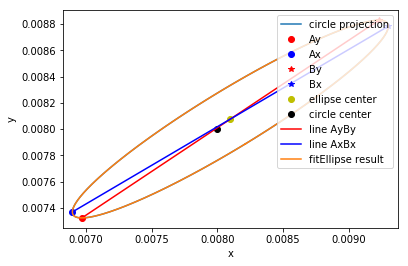

[0.0081000584121980485, 0.0080764366094837996] [0.00044164917573247275, 0.0028041579326398714] -58.681728863


In [466]:
f=0.008
radius = 1
#r_theta = 18*pi/180
r_theta = np.random.random()*pi
r_axis = [np.random.random()-0.5, np.random.random()-0.5, np.random.random()-0.5]
r = radius
Pc = [10, 10, 10]
draw_flag=False
#初始圆心在原点处
xc, yc, zc = 0, 0, 0
x, y = xyz_getCircle(xc, yc, r, num=500)
#获得物方点points
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y
points[:, 2] = zc
#将空间的点绕轴旋转
r_theta, r_axis, r_points, RR = xyz_rotation(points, r_theta=r_theta, r_axis=r_axis, draw_flag=False)
#平移到圆心处
xc, yc, zc = Pc[:]
r_points[:, 0] += xc
r_points[:, 1] += yc
r_points[:, 2] += zc
#焦平面成像
ff_x, ff_y = xyz_projection(r_points[:, 0:3], 'focal falt', draw_flag=draw_flag, f=f)
#圆中心投影
ff_xc, ff_yc = xyz_projection(np.array(Pc).reshape((1,3)), f=f)
scal = 30000
e_center, e_axes, e_angle = xyz_fitEllipse(ff_x, ff_y, fitStyle=0, scal=scal)
Ay, By, Ax, Bx = xyz_getExtremumFromEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
xyz_showResult(e_center, e_axes, e_angle, ff_x, ff_y, ff_xc, ff_yc, Ay, By, Ax, Bx, name='r_theta is ' + str(r_theta*180/pi) + '°')
plt.show()
print(e_center, e_axes, e_angle*180/pi)

# 测试

In [ ]:
#在jupyter notebook中显示
plt.switch_backend('nbAgg')
#在独立窗口显示
#plt.switch_backend('Qt5Agg')
print(xyz_getRelationData(Pc = [100, 100, 100], r_axis=[1, 0, 0], r_theta=45*pi/180, draw_flag=True, draw_result=True))
plt.show()

## 跑特殊数据分析

焦平面拟合椭圆效果很好

In [ ]:
#在jupyter notebook中显示
plt.switch_backend('nbAgg')
# 保持焦距，圆的半径，圆的中心不变,使用默认值
# f=0.03, Pc=[60,60,60], radius=60
# 绕着x轴旋转
r_axis = [1, 0, 0]
# 旋转角度变化范围[-pi, pi]
r_thetaList = np.arange(0, pi, pi/10)
for r_theta in r_thetaList:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle \
    = xyz_getRelationData(f=0.03, Pc=[100, 100, 100], radius=60, r_axis=r_axis, r_theta=r_theta, draw_flag=False, draw_result=True)
plt.show()

## 动画显示结果

/home/cyb/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


<IPython.core.display.Javascript object>


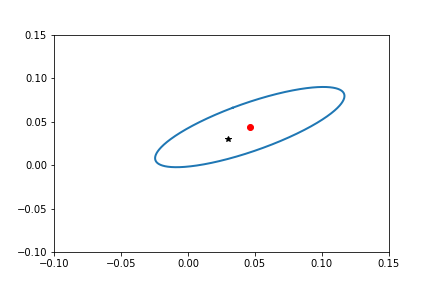

<IPython.core.display.Javascript object>


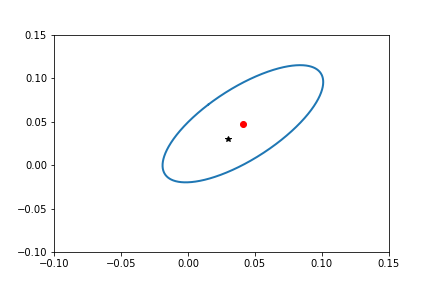

In [79]:
from matplotlib import animation
#在jupyter notebook中显示
plt.switch_backend('nbAgg')
#在独立窗口显示
#plt.switch_backend('Qt5Agg')

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
# create our line object which will be modified in the animation
ax = plt.axes(xlim=(-0.1, 0.15), ylim=(-0.1, 0.15))
# we simply plot an empty line: we'll add data to the line later
line, = ax.plot([], [], lw=2) 
point, = ax.plot([], [], 'ro', lw=2)
point_circle_center, = ax.plot([], [], 'k*', lw=2)
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    point.set_data([], [])
    point_circle_center.set_data([], [])
    return line,point,point_circle_center,
# animation function. This is called sequentially
# It takes a single parameter, the frame number i 
def animate(i):
    #x = np.linspace(0, 2, 1000)
    #y = np.sin(2 * np.pi * (x - 0.01 * i)) # update the data
    r_theta = 2*pi*i/360
    r_axis = [1, 0, 0]
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle \
    = xyz_getRelationData(f=0.03, Pc=[100, 100, 100], radius=60, r_axis=r_axis, r_theta=r_theta, draw_flag=False, draw_result=False)
    x, y = xyz_getEllipse(e_center[0], e_center[1], e_axes[0], e_axes[1], e_angle)
    line.set_data(x, y)
    point.set_data(e_center[0], e_center[1])
    point_circle_center.set_data(ff_xc, ff_yc)
    return line,point,point_circle_center,
# Makes an animation by repeatedly calling a function func
# frames can be a generator, an iterable, or a number of frames.
# interval draws a new frame every interval milliseconds.
# blit=True means only re-draw the parts that have changed.
# 在这里设置一个200帧的动画，每帧之间间隔20毫秒
anim = animation.FuncAnimation(fig, animate, init_func=init,
        frames=360, interval=20, blit=True)
# save the animation as an mp4. This requires ffmpeg or mencoder to be
# installed. The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5. You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show() # plt.show() 会一直循环播放动画

# 生成&&训练模型

## 数据形式

f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle =   
xyz_getRelationData(f=0.03, Pc=[60, 60, 60], radius=60, r_axis=[1, 1, 0], r_theta=0.0, draw_flag=False, draw_result=False)
1. input:
    - [f, radius, e_center[0,1], e_axes[0,1], e_angle]
    - m\*7  
    - 理想相机焦距，空间圆半径
        - 焦距f:float:meter
        - 圆半径radius:float:meter
    - 射影成像后，能够得到在焦平面上的信息，拟合椭圆信息
        - 椭圆中心e_center:list:[xe, ye]
        - 椭圆长短轴的一半e_axes:list:[a, b]
        - 椭圆倾斜角e_angle:float:弧度（逆时针）
- output:
    - [Pc[0,1,2], r_axis[0,1,2], r_theta]
    - m\*7  
    - 恢复三维圆的三维信息
        - 圆三维坐标Pc:
        - 圆旋转轴r_axis:list:[u,v,w]归一化后的，单位向量
        - 圆旋转角r_theta:float:弧度（逆时针）  
    - 其他信息
        - 旋转矩阵：RR：matrix：3\*3（RR=f(r_axis, r_theta)）
- 测试：
    - 预测Pc和实际Pc
    - 预测r_axis和实际r_axis
    - 预测r_theta和实际r_theta  

## 生成数据

In [123]:
def xyz_dataGenerate(f=0.03, radius=60, num=10000, length_range=[1, 3]):
    '''
    X, Y = xyz_dataGenerate()
    ----------------------
    -生成实验数据
    -给定f, radius, 随机生成Pc, r_axis, r_theta, 生成空间中的圆，并进行成像
    -f,radius自己设定
    -Pc:     圆中心Pc随机生成,xyz默认范围[1,3]*radius
    -r_axis: 旋转轴每一维取值范围[0, 1)
    -r_theta:旋转角度,弧度， 取值范围[0, pi)
    -----------------------
    input:
    f:相机焦距:float:meter
    radius:圆半径:float:meter
    num:数据数目:int
    length_range:圆的位置所在范围，默认范围[1,3]*radius，xyz三个坐标取值在该范围内:list:1*2
    -----------------------
    output:
    X:7维输入数据:np.array:m*7
    Y:7维输出数据:np.array:m*7
    -----------------------
    '''
    # 记录产生的数据
    # [f, radius, e_center[0,1], e_axes[0,1], e_angle]
    xyz_dataInput = []
    # [Pc[0,1,2], r_axis[0,1,2], r_theta]
    xyz_dataOutput = []
    # 生成数据量
    # num = 10000

    # 首先固定f，radius = 0.03， 60不变
    # f = 0.03
    # radius = 60
    for i in range(num):
        # 圆位置，旋转轴，旋转中心随机生成
        # 由于在拟合椭圆时，使用cv2.fitellipse，需要对应点都是正值，圆的位置需要大于半径radius
        # 圆位置每一维取值范围[radius, 3*radius]
        xc = (np.random.random()*(length_range[1] - length_range[0]) + length_range[0])*radius
        yc = (np.random.random()*(length_range[1] - length_range[0]) + length_range[0])*radius
        zc = (np.random.random()*(length_range[1] - length_range[0]) + length_range[0])*radius
        Pc = [xc, yc, zc]
        # 旋转轴每一维取值范围[0, 1)
        u = np.random.random()
        v = np.random.random()
        w = np.random.random()
        r_axis = [u, v, w]
        # 旋转角度,弧度， 取值范围[0, pi)
        r_theta = np.random.random()*pi
        # 已知f, radius, Pc, r_axis, r_theta, 生成空间中的圆，并进行成像
        f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
        xyz_getRelationData(f=f, Pc=Pc, radius=radius, r_axis=r_axis, r_theta=r_theta, draw_flag=False, draw_result=False)
        xyz_dataInput.append([f, radius, e_center[0], e_center[1], e_axes[0], e_axes[1], e_angle])
        xyz_dataOutput.append([xc, yc, zc, u, v, w, r_theta])
        
    return np.array(xyz_dataInput), np.array(xyz_dataOutput)

## 随机抽取数据，验证是否生成正确

In [345]:
def xyz_drawValidateData(X, Y, name='validate'):
    '''
    xyz_drawValidateDate()
    -------------------
    -如果两个椭圆重合，说明正确
    -------------------
    input:
    X:输入数据：list:1*7
    Y:预测数据：list:1*7
    name:str:画框名，两幅不同的图像起名最好不同
    -------------------
    '''
    [f, radius, xe, ye, a, b, phi] = X[:]
    [xc, yc, zc, u, v, w, r_theta] = Y[:]
    # 画出椭圆
    x, y = xyz_getEllipse(xe, ye, a/2, b/2, phi)
    plt.figure(name)
    plt.plot(x, y, 'r', label='trueGround')
    
    # 画出焦平面上的圆
    x, y = xyz_getCircle(0, 0, radius, num=500)
    #获得物方点points
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    points[:, 2] = 0
    #将空间的点绕轴旋转
    r_theta, r_axis, r_points, RR = xyz_rotation(points, r_theta=r_theta, r_axis=[u,v,w])
    #平移到圆心处
    r_points[:, 0] += xc
    r_points[:, 1] += yc
    r_points[:, 2] += zc
    #焦平面成像
    ff_x, ff_y = xyz_projection(r_points[:, 0:3], f=f)
    plt.plot(ff_x, ff_y, 'b', label='predict')
    plt.legend(loc='best')

# DecisionTreeRegressor

## 决策树回归，数据生成

In [125]:
# 10000组训练数据
X_train, Y_train = xyz_dataGenerate()
# 100组测试数据
X_test, Y_test = xyz_dataGenerate(num=100)

## 模型训练

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Fit regression model
regr = DecisionTreeRegressor(max_depth=8)
regr.fit(X_train, Y_train)

# Predict
y_trainPredict = regr.predict(X_train)
y_testPredict = regr.predict(X_test)

## 模型验证

In [171]:
def xyz_calcResidualMSE(y_true, y_predict):
    '''
    error = xyz_calcResidualMSE()
    ------------------
    计算均方误差
    sklearn库参考：
    from sklearn.metrics import mean_squared_error
    mean_squared_error()
    ------------------
    input:
    y_true:真值:np.array:m*n
    y_predict:预测值:np.array:m*n
    ------------------
    output:
    error:float:MSE均方误差
    ------------------
    '''
    residual_train = y_true - y_predict
    residual_train = residual_train**2
    # 按照每行求和
    residual_train = residual_train.sum(axis=1)
    
    return np.sum(np.sqrt(residual_train), axis=0)/y_true.shape[0]

### 训练集测试

MSE:  24.9569493495


<IPython.core.display.Javascript object>


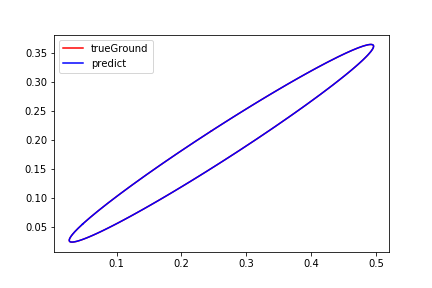

<IPython.core.display.Javascript object>


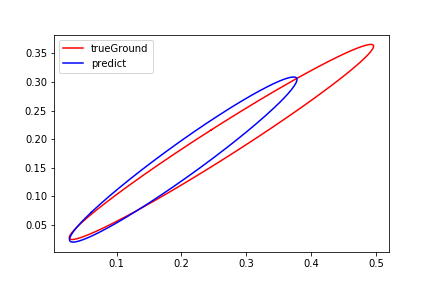

In [177]:
# 如果只使用真值进行测试，应该是100%的正确率
# 随机选取一个测试集中的数据进行验证
index = np.random.choice(range(X_train.shape[0]))
xyz_drawValidateData(X_train[index, :], Y_train[index, :], name=str(index))
xyz_drawValidateData(X_train[index, :], y_trainPredict[index, :], name=str(index)+'_predict')
# 计算均方误差
error_train = xyz_calcResidualMSE(Y_train, y_trainPredict)
print('MSE: ', error_train)
plt.show()

### 测试集测试

圆中心的真值:  [  89.83957894  112.08481713  124.67389588]
圆中心预测值:  [  81.98986392  108.22309744  110.59891416]
MSE:  27.0327909651


<IPython.core.display.Javascript object>


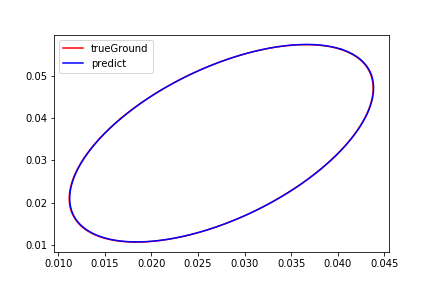

<IPython.core.display.Javascript object>


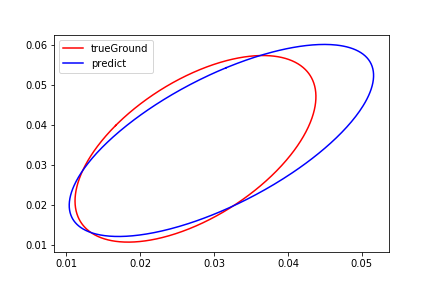

In [178]:
# 随机选取一个测试集中的数据进行验证
index = np.random.choice(range(X_test.shape[0]))
xyz_drawValidateData(X_test[index, :], Y_test[index, :], name=str(index))
xyz_drawValidateData(X_test[index, :], y_testPredict[index, :], name=str(index)+'_predict')
print('圆中心的真值: ', Y_test[index, 0:3])
print('圆中心预测值: ', y_testPredict[index, 0:3])
# 计算均方误差
error_test = xyz_calcResidualMSE(Y_test, y_testPredict)
print('MSE: ', error_test)
plt.show()

In [ ]:
X_test, Y_test = xyz_dataGenerate(num=100)

## max_depth树深度选择

<IPython.core.display.Javascript object>


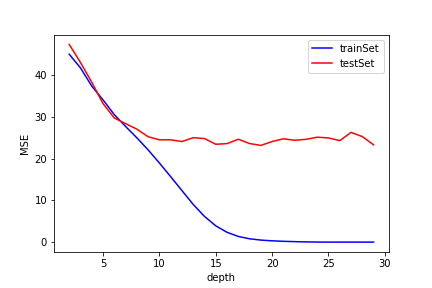

In [183]:
max_depth = range(2, 30)
MSE_train = []
MSE_test = []
for depth in max_depth:
    # Fit regression model
    regr = DecisionTreeRegressor(max_depth=depth)
    regr.fit(X_train, Y_train)

    # Predict
    y_trainPredict = regr.predict(X_train)
    y_testPredict = regr.predict(X_test)
    
    # 随机选取一个测试集中的数据进行验证
    # index = np.random.choice(range(X_train.shape[0]))
    # xyz_drawValidateData(X_train[index, :], Y_train[index, :], name=str(index))
    # xyz_drawValidateData(X_train[index, :], y_trainPredict[index, :], name=str(index)+'_predict')
    
    # 计算均方误差
    MSE_train.append(xyz_calcResidualMSE(Y_train, y_trainPredict))
    MSE_test.append(xyz_calcResidualMSE(Y_test, y_testPredict))
plt.figure('depth-error')
plt.plot(max_depth, MSE_train, 'b', label='trainSet')
plt.plot(max_depth, MSE_test, 'r', label='testSet')
plt.xlabel('depth')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

## 总结

- 随着深度增加，在训练集上，拟合得很好，没有错的(可能和决策树回归有关)  
- 在测试集上，大致在深度为10时，出现拐点
- 决策树模型训练误差可以出现0，是否说明自变量和相应变量之间一一对关系
    - 也就是说，空间中的圆和投影椭圆之间是唯一的对应关系，可以唯一确定<span class="mark">（好像是错的，能够确定两个空间中的圆）</span>
    - 只是没有想到好的建模方法
    - <span class="mark">同心圆怎么确定圆心的三维坐标</span>

# 模拟同心圆成像

## 给定Pc, r_axis, r_theta， 变化radius

<span class="burk"><span class="mark">是不是同心圆成像后，椭圆中心在同一条线上？</span></span>

<IPython.core.display.Javascript object>


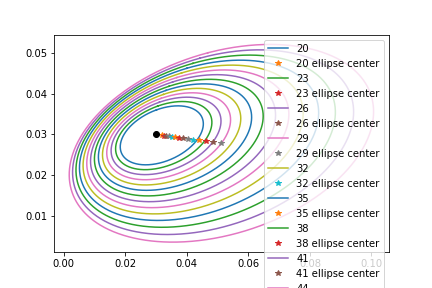

In [196]:
# 半径范围
radius = range(20, 60, 3)
plt.figure('Concentric circles')
r_theta=pi/6
for r in radius:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
    xyz_getRelationData(radius=r, r_theta=r_theta)
    x, y = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    plt.plot(x, y, label=str(r))
    plt.plot(e_center[0], e_center[1], '*', label=str(r)+' ellipse center')
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.legend(loc=1)
plt.show()

## 给定Pc，随机生成r_axis, r_theta，变化radius

<IPython.core.display.Javascript object>


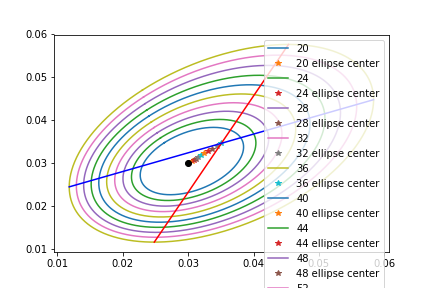

In [411]:
# 旋转轴每一维取值范围[0, 1)
plt.switch_backend('nbAgg')
u = np.random.random()
v = np.random.random()
w = np.random.random()
r_axis = [u, v, w]
# 旋转角度,弧度， 取值范围[0, pi)
r_theta = np.random.random()*pi
# 半径范围
radius = range(20, 60, 4)
plt.figure('Concentric circles')
#r_theta=pi/6
for r in radius:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
    xyz_getRelationData(radius=r, r_axis=r_axis, r_theta=r_theta)
    x, y = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    plt.plot(x, y, label=str(r))
    plt.plot(e_center[0], e_center[1], '*', label=str(r)+' ellipse center')
# 同心圆成像，确定的椭圆中心线，和极轴的关系？
plt.plot([Ay[0], By[0]], [Ay[1], By[1]], 'r', label='Ay-By')
plt.plot([Ax[0], Bx[0]], [Ax[1], Bx[1]], 'b', label='Ax-Bx')
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.legend(loc=1)
plt.show()

## 倾斜角和线之间的关系

- 空间中仅仅由圆的大小不同，产生的椭圆投影，椭圆中心不同，倾斜角度不同，<span class="mark">是否能够直接确定圆的投影中心？</span>  
    椭圆的五个自由度（xe, ye, a, b, theta）->确定圆心在焦平面上的投影（ff_xc, ff_yc）
    - 我觉得不行，理由
        - 还需要说明这是一个圆的投影，至少显示这是一个圆
        - 这是一个多大的圆（radius）
        - 圆的位姿（位置，倾斜角度，三维坐标，倾斜轴）
        
- 如果能确定圆心在焦平面上的投影(ff_xc, ff_yc)，是否能够使用论文中给定的方法，估计两个倾斜角？（可以，见第七章）  
    空间中的圆（任意位姿）在yoz、xoz平面上的投影是什么样的？（椭圆）
    - 是否能在yoz平面上找到线ACB，AC=BC=radius?（不能）
    - 是否能在xoz平面上找到线ACB，AC=BC=radius?（不能）

<IPython.core.display.Javascript object>


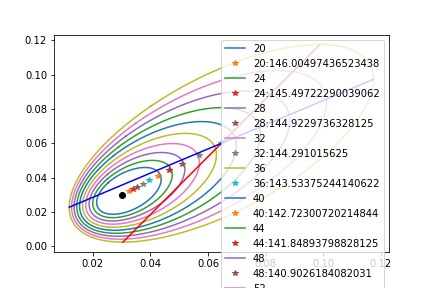

In [208]:
# 旋转轴每一维取值范围[0, 1)
u = np.random.random()
v = np.random.random()
w = np.random.random()
r_axis = [u, v, w]
# 旋转角度,弧度， 取值范围[0, pi)
r_theta = np.random.random()*pi
# 半径范围
radius = range(20, 60, 4)
plt.figure('Concentric circles')
#r_theta=pi/6
for r in radius:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
    xyz_getRelationData(radius=r, r_axis=r_axis, r_theta=r_theta)
    x, y = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    plt.plot(x, y, label=str(r))
    plt.plot(e_center[0], e_center[1], '*', label=str(r)+':'+str(e_angle*180/pi))
# 同心圆成像，确定的椭圆中心线，和极轴的关系？
plt.plot([Ay[0], By[0]], [Ay[1], By[1]], 'r', label='Ay-By')
plt.plot([Ax[0], Bx[0]], [Ax[1], Bx[1]], 'b', label='Ax-Bx')
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.legend(loc=1)
plt.show()

# 如果准确知道(ff_xc, ff_yc)

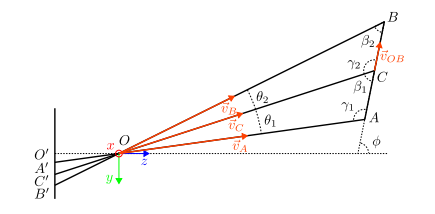

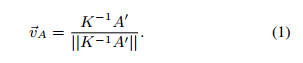

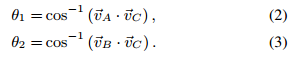

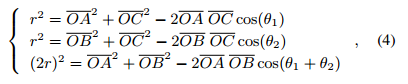

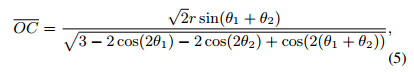

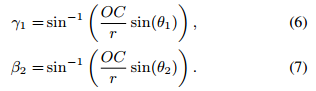

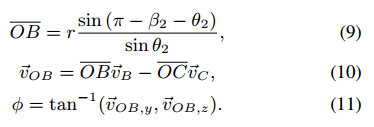

## 计算过程

如果现在准确知道了空间中圆心点投影点${C^{'}}$所在焦平面的坐标${C^{'}}$(ff_xc, ff_yc)，则能通过拟合的椭圆得到圆的位姿，具体过程如下：  
1. 获得焦平面上过点${C^{'}}$，平行y轴的线段${A_y^{'}B_y^{'}}$，其中${A_y^{'}}$${B_y^{'}}$在椭圆上
    - 上图显示的是空间平面OC${B_y^{'}}$，是由圆中心坐标C和原点O以及C在xoz平面上的投影点C_xoz确定的平面
    - 角度${\phi}$也是在面OC${B_y^{'}}$上，向量C${B_y^{'}}$和向量OC_xoz的夹角
- 通过论文过程估计向量C${B_y^{'}}$
- 获得焦平面上过点${C^{'}}$，平行x轴的线段${A_x^{'}B_x^{'}}$，其中${A_x^{'}}$${B_x^{'}}$在椭圆上
    - 上图显示的是空间平面OC${B_x^{'}}$，是由圆中心坐标C和原点O以及C在yoz平面上的投影点C_yoz确定的平面
    - 角度${\phi}$也是在面OC${B_x^{'}}$上，向量C${B_x^{'}}$和向量OC_yoz的夹角
- 通过论文过程估计向量C${B_x^{'}}$
- 确定圆的位置${C}$
    - <span class="mark">能够估计向量OC_y, OC_x（二者很有可能不同），方向相同，但是长度可能计算不同（怎么解决）？</span>
- 如果知道两个向量${CB_y^{'}}$和向量${CB_x^{'}}$，以及圆的位置${C}$，则能在空间中唯一确定圆
    - 相当于知道空间中圆上的三点，则能唯一确定一个圆（实际上是确定圆所在平面，由于半径已知，故能唯一确定空间中的圆）

### 模拟计算说明

假设已知圆在焦平面上的投影点${C^{'}}$，和焦平面上的椭圆(e_center, e_axes, e_angle)，圆半径radius，焦距f，按照论文上的方式计算圆的位姿。  
- 圆只需要绕着Z轴旋转即可，可以简化旋转函数，只有两个自由度，平面的法向量旋转到和Z平行即可
- <span class="mark">是否两次计算圆的中心长度一致？很有可能不一样（因为圆中心投影点是不精确的）</span>
    - 使用同心圆确定的${C^{'}}$作为初始值，选择周围的一个区域，计算${d(C^{'}, \gamma, Q^{'})}$
    - 如果每一次计算的d都相同，则${C^{'}}$是一个候选值，实际可以使用最小方差来决定${C^{'}}$
    - <span class="mark">如果是准确值，会发现在周围区域有两个最优值，这是由于对称性造成的（是否说这两个空间圆，成像后的椭圆相同？）××××××</span>
- 如何确定这两个最优值
    - P260

按照之前的方式进行计算，先看计算的圆和给定的圆是否一致？  
如果一致，尝试找另外一个对称的圆，在焦平面上的投影也是相同的椭圆？怎么找？
- 找到过圆心的直径（A，C，B)，分别是x,y两个方向的
- 找到对称轴, ∠AOB的角平分线
- 找到点C关于该角平分线对称的点C‘，AB的对应点A‘，B’
- 以点C’作为圆心，计算圆的位姿，在空间成像
- 然后将圆C‘在焦平面上投影，观察是否一致

### 求解lineAndEllipse焦点（testAndPlot）

<IPython.core.display.Javascript object>


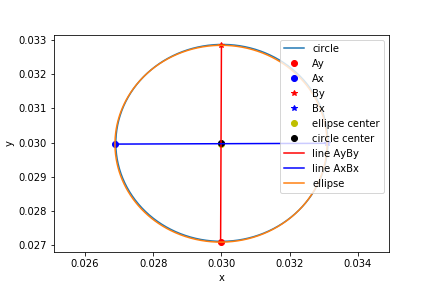

<IPython.core.display.Javascript object>


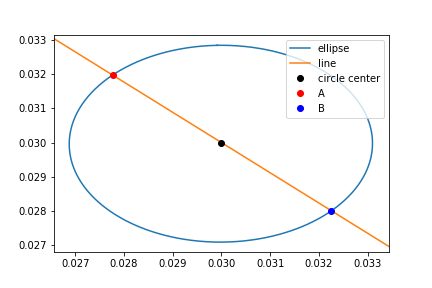

In [446]:
f=0.08
f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle=\
xyz_getRelationData(Pc=[10, 10, 10], radius=1, r_theta=3*pi/180, draw_result=True, scal=20000)
gamma = np.random.random()*pi
Ap, Bp = xyz_calcIntersectionOfLineAndEllipse(ff_xc, ff_yc, gamma, e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
x_e, y_e = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
x_l, y_l = xyz_getLine(ff_xc, ff_yc, gamma, length=0.05)
[xmin, xmax, ymin, ymax] = plt.axis()
plt.figure()
plt.plot(x_e, y_e, label='ellipse')
plt.plot(x_l, y_l, label='line')
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.plot(Ap[0], Ap[1], 'ro', label='A')
plt.plot(Bp[0], Bp[1], 'bo', label='B')
#plt.axis([Ax[0], Bx[0], Ay[1], By[1]])
plt.axis([xmin, xmax, ymin, ymax])
plt.legend(loc=1)
plt.show()

### 求解投影线对应空间圆上的一点(testAndPlot)

1. 误差来源：
    1. 成像误差
    - 椭圆估计误差
        1. 导致圆中心投影估计误差
        - 过圆中心的线反变换回去不是在直径上
    - 计算精度问题，在估计椭圆的时候，不使用cv.fitellipse?
2. 误差规律：
    1. 圆离得越远，误差越大 
3. 假设：
    1. 圆总体上是朝着相机的，倾斜的角度不大  

**旋转轴是[1, -1, 0]，旋转角度变化，和估计的phi的整体趋势**  
当旋转角大致为36°时，成像几乎是一条直线，此时估计误差大  
${sin\phi = \frac{\sqrt3}{3}}$

0.0 9.87372762474 9.87372762474 9.87372762474
9.0 9.82475737462 9.82475737462 9.82475737462
18.0 9.7159806629 9.7159806629 9.7159806629
27.0 9.46393829129 9.46393829129 9.46393829129
36.0 31.8050286956 31.8050286956 31.8050286956
45.0 10.5451750682 10.5451750682 10.5451750682
54.0 10.2668039818 10.2668039818 10.2668039818
63.0 10.1728728264 10.1728728264 10.1728728264
72.0 10.118057689 10.118057689 10.118057689
81.0 10.0855432626 10.0855432626 10.0855432626


<IPython.core.display.Javascript object>


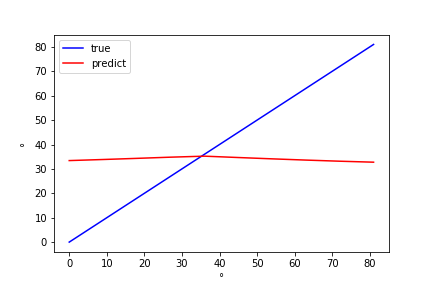

In [449]:
theta_List = np.arange(0, 90, 90/10)
f=0.08
phi_List = []
for r_theta in theta_List:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], [xe, ye], [a_2, b_2], phi=\
    xyz_getRelationData(f=f, Pc = [10, 10, 10], radius=1, r_axis=[1, -1, 0], r_theta=r_theta*pi/180, scal=100000)
    a = a_2/2
    b = b_2/2
    # 求解空间圆上的一点
    [xc, yc, zc], [xa, ya, za], voa, vob, voc, phi = \
    xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=pi/4, f=f, radius=radius)
    print(r_theta*180/pi, xc, yc, zc)
    phi_List.append(90 - phi*180/pi)
plt.figure()
plt.plot(theta_List, theta_List, 'b', label='true')
plt.plot(theta_List, phi_List, 'r', label='predict')
plt.xlabel('°')
plt.ylabel('°')
plt.legend()
plt.show()

- 三个向量：
[ 0.27426276  0.27426276  0.92171572]
[ 0.65156116  0.65156116  0.38850496]
[ 0.57735027  0.57735027  0.57735027]
- 两个theta角度：
31.913822485573075 12.40288389651428
- 圆半径，oc投影长度
10 17.297946967330695
- gama1, beta2分别可能的2个解：
66.12690287449293 113.87309712550707 21.81019649240556 158.18980350759443
- gama1, beta2解：
2 113.87309712550707 21.81019649240556
- ob投影长度：
146.59923889930627
- cb向量：
[ 85.53139599  85.53139599  46.96755758]
- 倾斜角度phi：
68.77925264567372
圆心坐标： 9.98697433802 9.98697433802 9.98697433802
A坐标： 95.5183703266 95.5183703266 56.9545319193


<IPython.core.display.Javascript object>


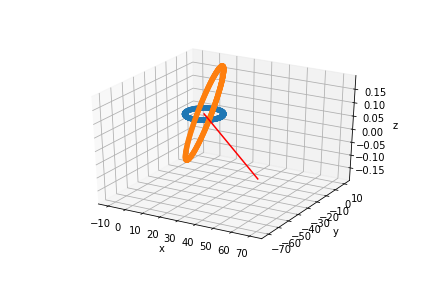

<IPython.core.display.Javascript object>


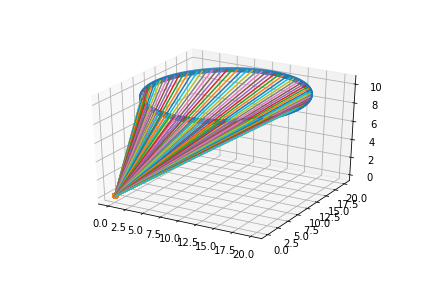

<IPython.core.display.Javascript object>


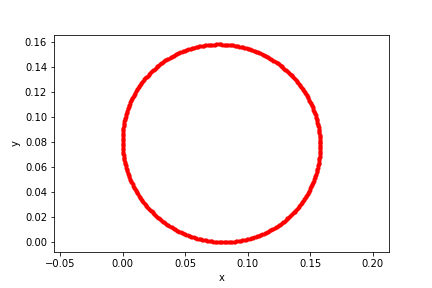

<IPython.core.display.Javascript object>


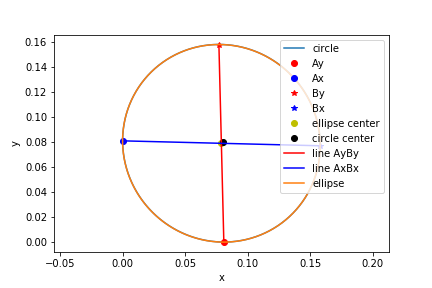

<IPython.core.display.Javascript object>


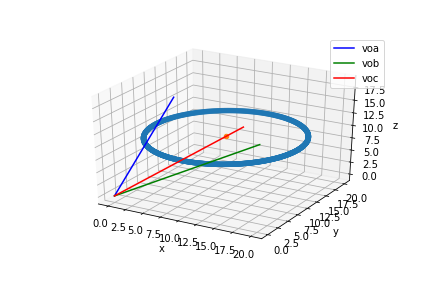

In [455]:
# -已知f, radius, Pc, r_axis, r_theta, 生成空间中的圆，并进行成像
f=0.08
Pc=[10, 10, 10]
radius=1
f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], [xe, ye], [a_2, b_2], phi=\
xyz_getRelationData(f=f, Pc=Pc, radius=radius, r_axis=[1, -1, 0], r_theta=1*pi/180, draw_result=True, draw_flag=True, scal=10000)
a = a_2/2
b = b_2/2
# 求解空间圆上的一点
[xc, yc, zc], [xa, ya, za], voa, vob, voc, phi = \
xyz_calcCircleCenterAndAPoint(ff_xc, ff_yc, xe, ye, a, b, phi, gamma=pi/4, f=f, radius=radius, show_message=True)
print('圆心坐标：', xc, yc, zc)
print('A坐标：', xa, ya, za)
# plot result
fig = plt.figure('xyz')
ax = fig.add_subplot(1,1,1, projection='3d')
x, y = xyz_getCircle(0, 0, radius)
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y
points[:, 2] = 0
r_theta, r_axis, points_extent_draw, RR = xyz_rotation(points, r_theta=r_theta, r_axis=r_axis)
points_extent_draw[:, 0] += Pc[0]
points_extent_draw[:, 1] += Pc[1]
points_extent_draw[:, 2] += Pc[2]
ax.scatter(points_extent_draw[:,0], points_extent_draw[:,1], points_extent_draw[:,2])
scal = 20
ax.plot3D([voa[0]*scal, 0], [voa[1]*scal, 0], [voa[2]*scal, 0], 'b', label='voa')
ax.plot3D([vob[0]*scal, 0], [vob[1]*scal, 0], [vob[2]*scal, 0], 'g', label='vob')
ax.plot3D([voc[0]*scal, 0], [voc[1]*scal, 0], [voc[2]*scal, 0], 'r', label='voc')
ax.scatter(Pc[0], Pc[1], Pc[2], 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.show()

In [403]:
print(points_extent_draw[1:10, :])
print(xe, ye)
print(np.dot(RR, np.array([1,1,0,1])))

[[ 151.15692653   91.53547925  130.18808964    1.        ]
 [ 151.098626     91.85808991  130.37498512    1.        ]
 [ 151.03830414   92.18102263  130.56067904    1.        ]
 [ 150.97596334   92.50426466  130.74516406    1.        ]
 [ 150.91160606   92.82780319  130.92843289    1.        ]
 [ 150.84523486   93.15162544  131.11047827    1.        ]
 [ 150.77685235   93.47571859  131.291293      1.        ]
 [ 150.70646124   93.80006983  131.47086993    1.        ]
 [ 150.63406432   94.12466632  131.64920195    1.        ]]
0.031877780151367184 0.03188212280273438
[ 0.70710678  0.70710678  1.          1.        ]


## 空间中圆在yoz平面上的投影

论文中投影平面有误，不是在yoz平面上，而是在圆中心坐标C和原点O以及C在xoy平面上的投影点C_xoy确定的平面

<span class="mark">实际上并非是投影面，是在空间中平面，由光心O和过C’的直线确定的平面</span>

可以从图中观察，椭圆长轴长不总是2倍的半径；空间圆在yoz平面上投影，不能找到长度为2倍半径的线段。

a: 16.859393310546874, b: 119.9733203125


<IPython.core.display.Javascript object>


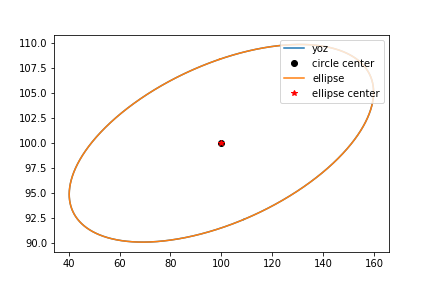

In [275]:
# 产生一个空间中圆
# f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle \
# = xyz_getRelationData(f=0.03, Pc=[60, 60, 60], radius=60, r_axis=[1, 1, 0], r_theta=0.0, draw_flag=False, draw_result=False)
radius = 60
xc, yc, zc = 100, 100, 100
# 旋转轴每一维取值范围[0, 1)
u = np.random.random()
v = np.random.random()
w = np.random.random()
r_axis = [u, v, w]
# 旋转角度,弧度， 取值范围[0, pi)
r_theta = np.random.random()*pi

x, y = xyz_getCircle(0, 0, radius, num=10000)
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y
points[:, 2] = 0
# 旋转一个角度
r_theta, r_axis, r_points, RR = xyz_rotation(points, r_theta=r_theta, r_axis=r_axis)
r_points[:, 0] += xc
r_points[:, 1] += yc
r_points[:, 2] += zc
# 在yoz平面上进行投影
# 在yoz平面投影是否是一个椭圆？
yoz_center, yoz_axes, yoz_angle = xyz_fitEllipse(r_points[:, 1], r_points[:, 2], scal=200)
x_e, y_e = xyz_getEllipse(yoz_center[0], yoz_center[1], yoz_axes[0]/2, yoz_axes[1]/2, yoz_angle)
# plot显示结果
plt.figure()
plt.plot(r_points[:, 1], r_points[:, 2], label='yoz')
plt.plot(yc, zc, 'ko', label='circle center')
plt.plot(x_e, y_e, label='ellipse')
plt.plot(yoz_center[0], yoz_center[1], 'r*', label='ellipse center')
print('a: {}, b: {}'.format(yoz_axes[0], yoz_axes[1]))
plt.legend(loc=1)
plt.show()

# 模拟圆位置相同，位姿不同成像

## 绕轴[1, -1, 0]旋转，圆位置[10, 10, 10]，radius=1

r_theta is 0.0, ellipse center is -1.1978854817838857e-20,6.203797364666154e-22
r_theta is 0.3, ellipse center is -2.9618686358926e-07,-2.961868635892625e-07
r_theta is 0.6, ellipse center is -5.923417341107653e-07,-5.923417341107643e-07
r_theta is 0.9, ellipse center is -8.884326217937662e-07,-8.884326217937972e-07
r_theta is 1.2, ellipse center is -1.184427543462418e-06,-1.1844275434624424e-06
r_theta is 1.5, ellipse center is -1.4802945258317103e-06,-1.4802945258318297e-06
r_theta is 1.8, ellipse center is -1.7760016088036229e-06,-1.7760016088035915e-06
r_theta is 2.1, ellipse center is -2.0715168487614107e-06,-2.0715168487614133e-06
r_theta is 2.4, ellipse center is -2.3668083218634005e-06,-2.3668083218633366e-06
r_theta is 2.7, ellipse center is -2.661844127334304e-06,-2.6618441273343143e-06
circle center project position is [ 0.],[ 0.]


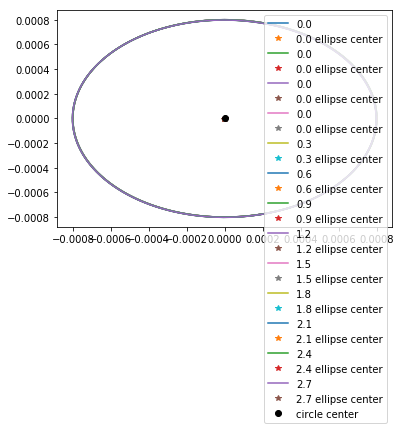

In [472]:
# 倾斜角范围
f = 0.008#8 mm
r_thetaList = np.arange(0, 3, 3/10)
plt.figure('r_theta change [0, 3]')
radius = 1
Pc = np.array([0, 0, 10])
r_axis = [1, -1, 0]
for r_theta in r_thetaList:
    f, Pc, radius, r_axis, r_theta, RR, [ff_xc, ff_yc], [Ay, By, Ax, Bx], e_center, e_axes, e_angle = \
    xyz_getRelationData(f=f, Pc=Pc, r_axis=r_axis, radius=radius, r_theta=r_theta*pi/180, scal=10000)
    x, y = xyz_getEllipse(e_center[0], e_center[1], e_axes[0]/2, e_axes[1]/2, e_angle)
    plt.plot(x, y, label=str(r_theta*180/pi))
    plt.plot(e_center[0], e_center[1], '*', label=str(r_theta*180/pi)+' ellipse center')
    print('r_theta is {:.1f}, ellipse center is {},{}'.format(r_theta*180/pi, e_center[0], e_center[1]))
print('circle center project position is {},{}'.format(ff_xc, ff_yc))
plt.plot(ff_xc, ff_yc, 'ko', label='circle center')
plt.legend(loc=1)
plt.show()

# 同心圆成像，确定ff_xc, ff_yc

# 两个固定相机成像，确定ff_xc,ff_yc